In [2]:
import multiprocessing
print(f'num cpus: {multiprocessing.cpu_count()}')

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import scipy as sp
import sklearn.datasets

import frame_whitening as fw
import frame_whitening.plot as fwplt
from frame_whitening import simulation as fws

num cpus: 128


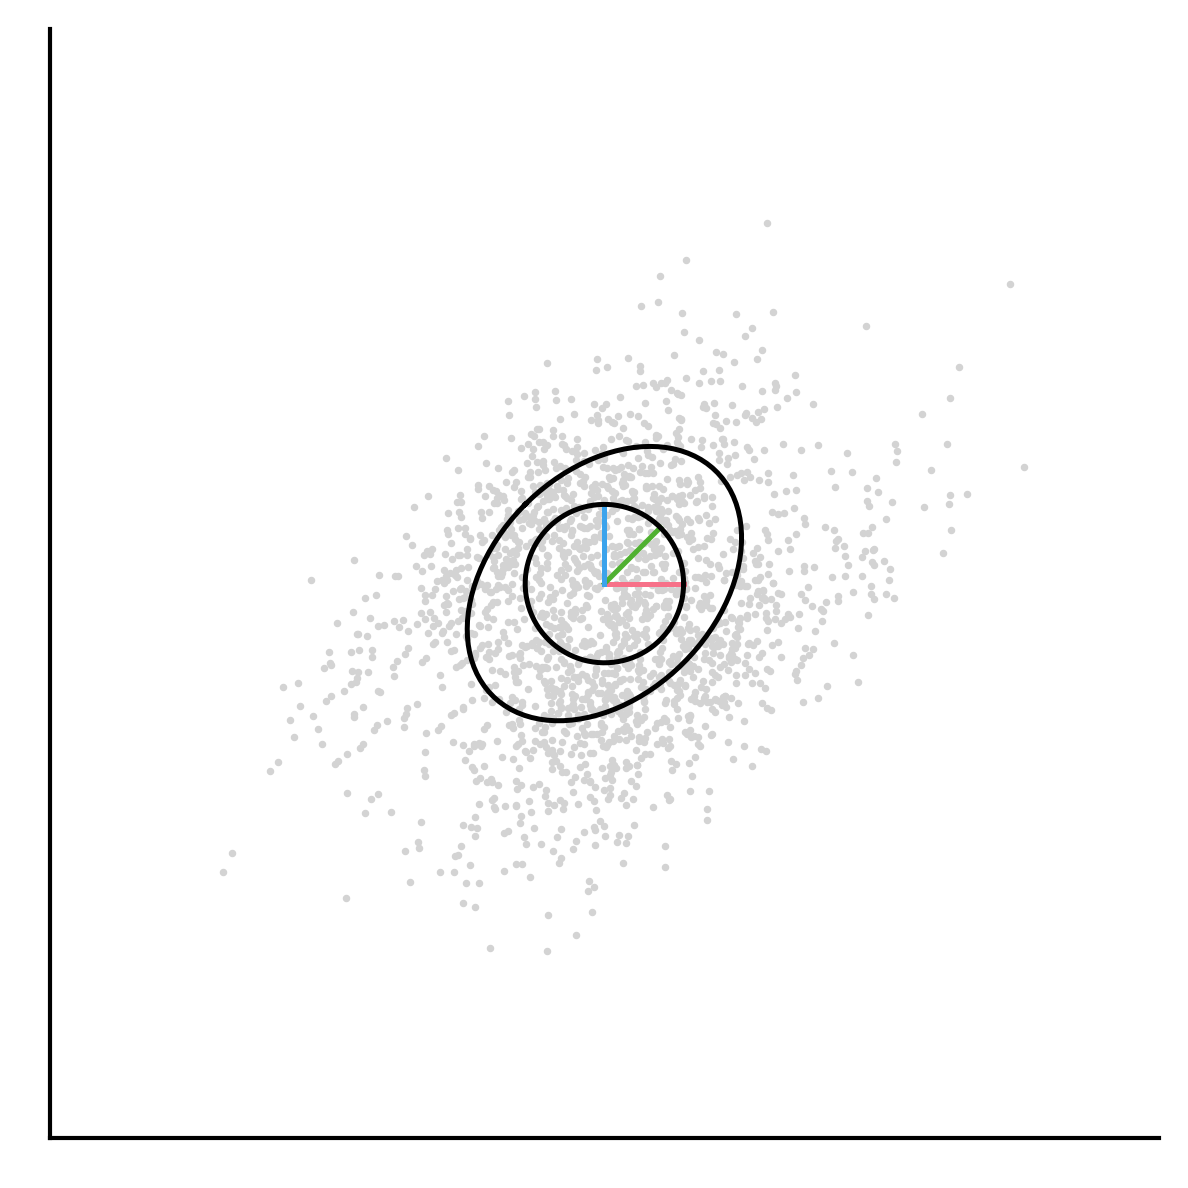

In [3]:
n_samples = 1000
N = 2
np.random.seed(42069)

X, y = sklearn.datasets.make_moons(n_samples=n_samples, noise=.28)

X = X - X.mean()

Cxx = np.array([
    [3, 1],
    [1, 3]
])

Lxx = sp.linalg.sqrtm(Cxx)

tmp = np.linalg.inv(np.cov(X.T))
L12 = np.linalg.cholesky(tmp)

Xw = X @ L12
X0 = Xw @ Lxx
np.cov(X0.T)


F = np.array([[1, 1/np.sqrt(2), 0],
              [0, 1/np.sqrt(2), 1]])

with sns.plotting_context("paper", font_scale=1.5):
  fig, ax = plt.subplots(1, 1, dpi=300, sharex="all", sharey="all")
  ax.scatter(*X0.T, color="lightgrey", s=1)
  ax.axis("square")
  fwplt.plot_ellipse(Cxx, n_pts=100, ax=ax, color="k", stdev=1.)

  cols = sns.color_palette("husl", 3)
  for i, f in enumerate(F.T):
    ax.plot([0, f[0]], [0, f[1]], color=cols[i])

  ax.scatter(*Xw.T, color="lightgrey", s=1)
  fwplt.plot_ellipse(np.eye(2), n_pts=100,  ax=ax, color="k", stdev=1.)
  axlim = 7
  ax.set(xticks=[], yticks=[], xlim=(-axlim,axlim), ylim=(-axlim, axlim))
  sns.despine()

  fig.savefig("tmp.pdf")

In [23]:
seed = 42069
np.random.seed(seed)
n, k = 2, 3
n_batch = 5000
lr_g = 2E-3
online = True
batch_size = 1

theta = np.deg2rad(55)
V = np.array([[np.cos(theta), -np.sin(theta)], [np.sin(theta), np.cos(theta)]])
Cxx0 = V @ np.diag([4, 1]) @ V.T * 0.1
Cxx0 *= 50

# V, _ = np.linalg.qr(np.random.randn(n, n))
Cxx1 = V @ np.diag([3, 2]) @ V.T * 0.1
Cxx1 *= 40

cholesky_list = [np.linalg.cholesky(C) for C in [Cxx0, Cxx1]]
Cxx_list = (Cxx0, Cxx1)
W = fw.get_mercedes_frame()
W = np.array([[0, 1, 1], [1, 1, 0]])
W = fw.normalize_frame(W)

g0 = np.array([0.01, 1.2, 0.25])
g, g_all, errors, variances = fws.adapt_covariance(Cxx_list, W, batch_size, n_batch, lr_g, g0=g0, online=online, seed=seed)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 8843.03it/s]


In [24]:
def get_variances(g, W, Cxx):
    N = W.shape[0]
    Ixx = np.eye(N)
    WGW = W @ np.diag(g) @ W.T
    M = np.linalg.inv(Ixx + WGW)
    Cyy = M @ Cxx @ M.T
    Czz = W.T @ Cyy @ W
    variances = np.diag(Czz)
    return variances

vars = []
g_all2 = [g for g in g_all]
for j, Cxx in enumerate([Cxx0, Cxx1]):
    for i in range(n_batch):
        vars.append(get_variances(g_all2.pop(0), W, Cxx))

vars = np.stack(vars)

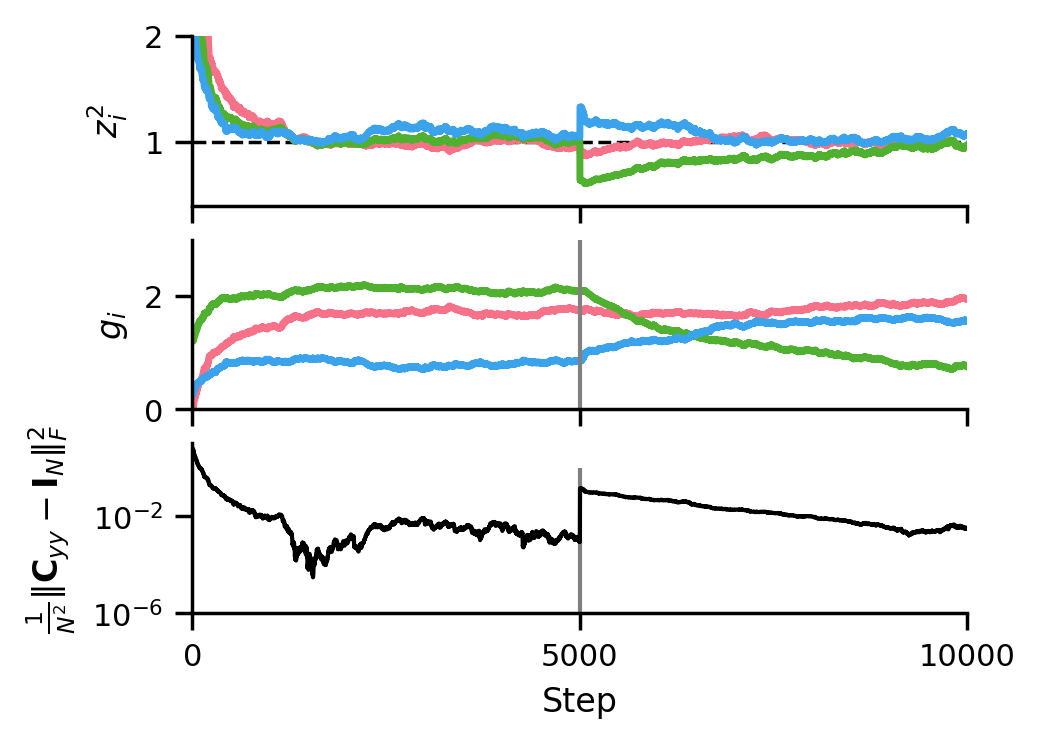

In [28]:
with sns.plotting_context("paper", font_scale=1):

    cols = sns.color_palette("husl", 3)
    fig, ax = plt.subplots(3, 1, figsize=(4, 3), sharex="all", dpi=250)

    for i in range(k):
        ax[0].plot(vars[:,i], color=cols[i], linewidth=2)


    ax[0].hlines(
        1, 1, 2*n_batch, color="k", linestyle="--", linewidth=1.,  zorder=-1)


    g_opt0 = fws.get_g_opt(W, Cxx0)
    g_opt1 = fws.get_g_opt(W, Cxx1)
    g_opt = [g_opt0, g_opt1]

    for i in range(k):
        ax[1].plot(g_all[:,i], color=cols[i], linewidth=2)
        # ax[1].hlines(g_opt0[i], 0, n_batch, color=cols[i], linestyle='--', lw=1.5)
        # ax[1].hlines(g_opt1[i], n_batch, 2*n_batch, color=cols[i], linestyle='--', lw=1.5)
    ax[1].vlines(n_batch, 0, 3, color="grey", linestyle='-')
    ax[2].vlines(n_batch, 1E-10, 1, color="grey", linestyle='-')

    ax[0].set(ylabel=r"$z_i^2$", yscale="linear", ylim=(.4, 2))
    # ax[0].set(ylabel=r"$z_i^2$", yscale="linear", ylim=(0, 5))
    ax[1].set(ylabel=r"$g_i$", xlim=(0, n_batch * len(cholesky_list)), ylim=(0, 3),
    xticks=(0, n_batch, 2*n_batch))
    ax[2].plot(errors, "k")

    ax[2].set(ylabel=r"$\frac{1}{N^2}\Vert{\bf C}_{yy} - {\bf I}_N\Vert_{F}^2$", xlabel="Step", 
    yscale="log", ylim=(1E-6, 10))
    sns.despine()


In [69]:
from matplotlib.patches import Ellipse
def plot_cov_ellipse(cov: np.ndarray, stdev: float, ax=None, **kwargs):
    """Plot a solid or outline of ellipse with a given position and covariance."""

    E, V = np.linalg.eigh(cov)
    if ax is None:
            ax = plt

    order = E.argsort()[::-1]
    E, V = E[order], V[:, order]
    theta = np.degrees(np.arctan2(*V[:, 0][::-1]))
    # Width and height are "full" widths (diameter), not radius
    width, height = 2*stdev*np.sqrt(E)
    ellipse = Ellipse(xy=(0,0), width=width, height=height, angle=theta, **kwargs)
    ax.add_artist(ellipse)


[(-5.0, 5.0), (-5.0, 5.0), [], []]

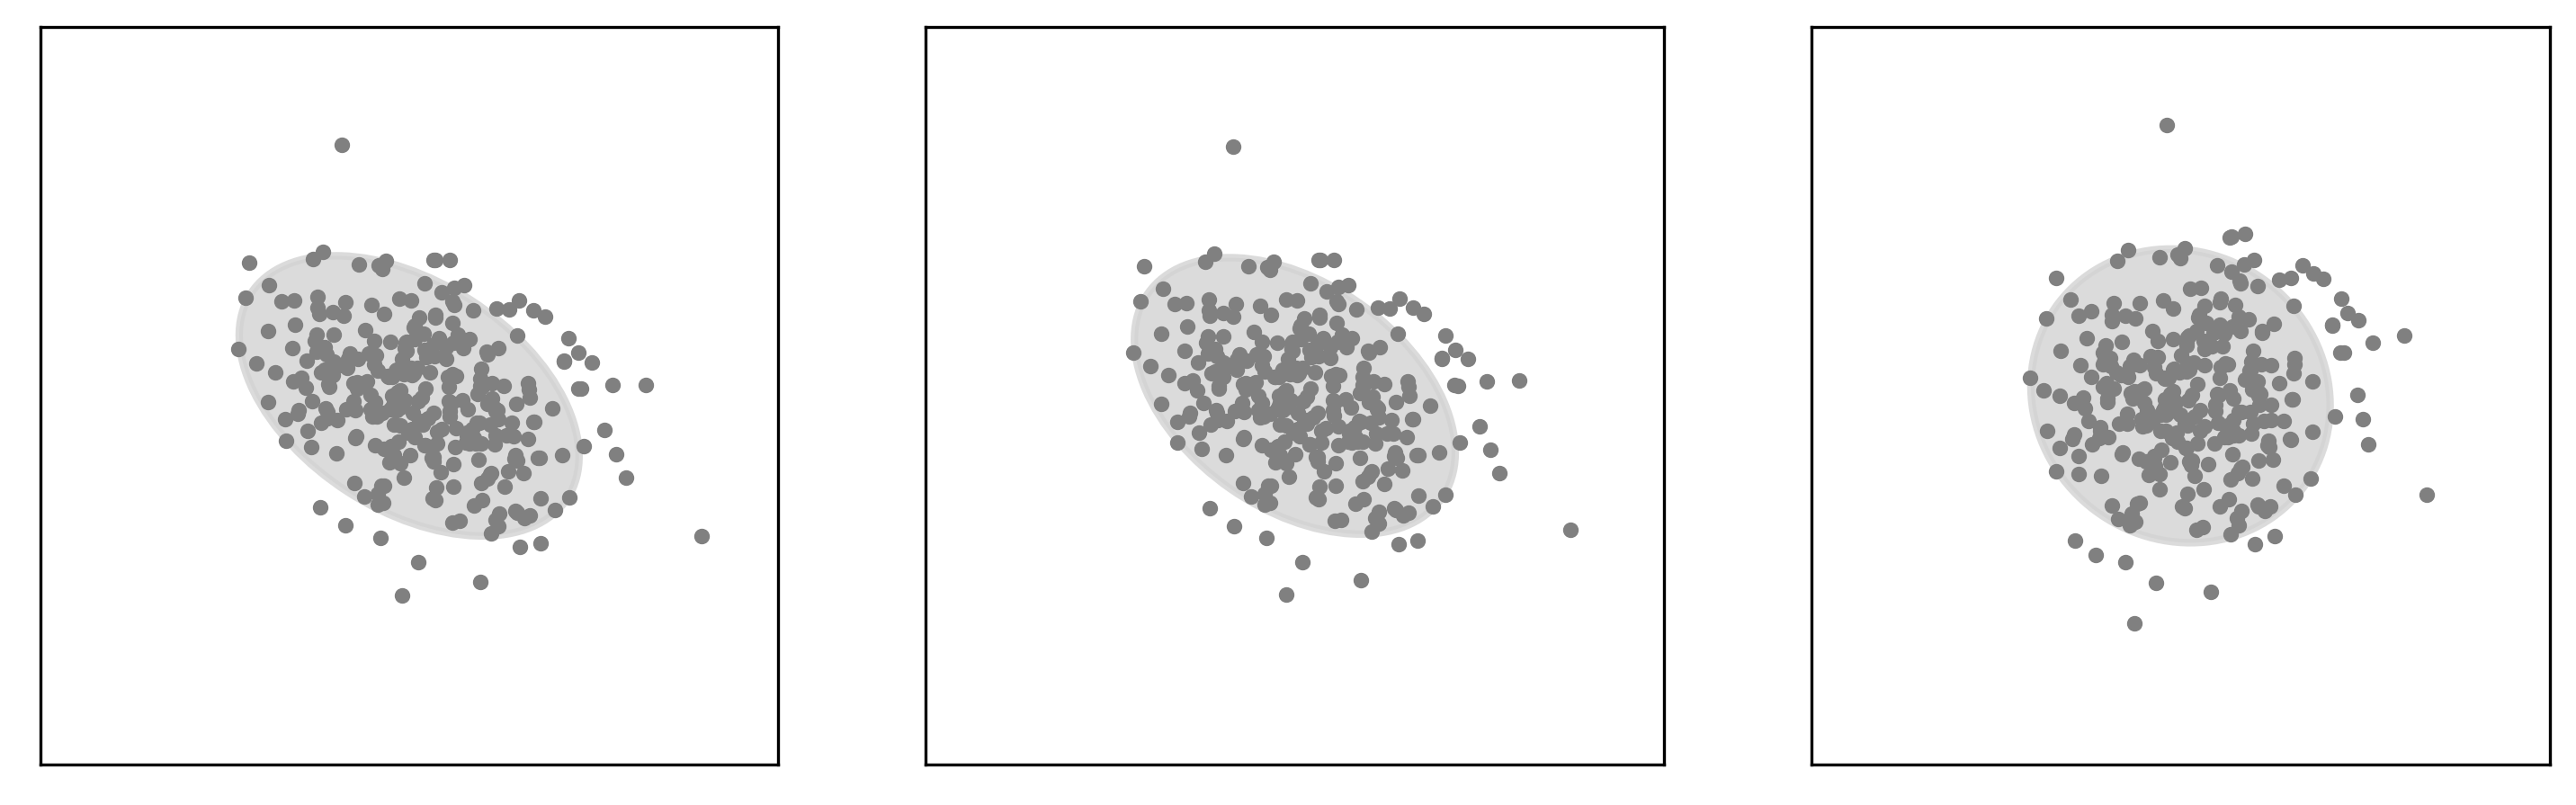

In [123]:
fig, ax = plt.subplots(1, 3, figsize=(12, 4), sharex='all', sharey='all', dpi=300)
rng = np.random.default_rng(seed)

n_pts = 300
data0 = rng.standard_normal((n_pts, 2)) @ cholesky_list[0].T
data1 = rng.standard_normal((n_pts, 2)) @ cholesky_list[1].T
data, C, mult = data1, Cxx1, 1

Q = np.linalg.qr(rng.standard_normal((2, 2)))[0]

t_list = np.array((00, 100, 4500)) + mult*n_batch
M = np.linalg.inv(np.eye(2) + W @ np.diag(g_all[t_list[0]]) @ W.T)
M1 = np.linalg.inv(np.eye(2) + W @ np.diag(g_all[t_list[1]]) @ W.T)
M2 = np.linalg.inv(np.eye(2) + W @ np.diag(g_all[t_list[2]]) @ W.T)
ax[0].scatter(*(data@M).T, color='grey', s=10)
ax[1].scatter(*(data @ M1).T, color='grey', s=10)
ax[2].scatter(*(data @ M2).T, color='grey', s=10)


plot_cov_ellipse(M@C@M, 2, ax=ax[0], color='lightgrey', linewidth=2, alpha=.8, zorder=-1)
plot_cov_ellipse(M1@C@M1, 2, ax=ax[1], color='lightgrey', linewidth=2, alpha=.8, zorder=-1)
plot_cov_ellipse(M2@C@M2, 2, ax=ax[2], color='lightgrey', linewidth=2, alpha=.8, zorder=-1)

lims = (-5, 5)
ax[0].axis('square')
ax[0].set(xlim=lims, ylim=lims, xticks=[], yticks=[])


ax[1].axis('square')
ax[1].set(xlim=lims, ylim=lims, xticks=[], yticks=[])
ax[2].axis('square')
ax[2].set(xlim=lims, ylim=lims, xticks=[], yticks=[])

# sns.despine()